# SQL Capstone Project

In this notebook, I perform data analysis using to reach answers to some of the questions explained in first notebook - 

   1. Are female atheletes equally represented as males in different regions? 
   2. Does there exist a bias between player’s age and the sports?
   3. Are all sports dominated by few countries or the distribution varies depending on the sports?

Here are my initial hypothesis - 

1. The representation of males and females may be more fair in developed nations compared to developing nations, where opportunities are not equally available. 
2. Age distribution of players should not vary a lot between different type of sports. 
3. More developed nations would have higher dominance in majority of sports due to better infrastructure and opportunities provided to their players. 


In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf
import os
import matplotlib as mpl
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)
mpl.rc('axes', labelsize=16, grid=True)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)


# Dataset 

In [2]:
# Import the data using pandas

athlete_events = pd.read_csv('../Dataset/athlete_events.csv')
noc_data = pd.read_csv('../Dataset/noc_regions.csv')


#Combine the datasets
pysqldf = lambda q:sqldf(q, globals())
player_stats = pysqldf('SELECT ath.*, noc.region AS Region\
                        FROM athlete_events AS ath \
                        LEFT OUTER JOIN noc_data AS noc \
                        ON ath.NOC=noc.NOC \
                        ORDER BY noc.NOC')
    
player_stats.head(10)

ID                             Name Sex   Age  Height  Weight       Team  \
0   332                 Zarinah Abdullah   F  21.0     NaN     NaN  Singapore   
1   332                 Zarinah Abdullah   F  25.0     NaN     NaN  Singapore   
2  1515  Saiyidah Aisyah Mohamed Rafa'ee   F  28.0   173.0    68.0  Singapore   
3  4264                   Ang Peng Siong   M  21.0   180.0    75.0  Singapore   
4  4264                   Ang Peng Siong   M  21.0   180.0    75.0  Singapore   
5  4264                   Ang Peng Siong   M  21.0   180.0    75.0  Singapore   
6  4264                   Ang Peng Siong   M  21.0   180.0    75.0  Singapore   
7  4264                   Ang Peng Siong   M  25.0   180.0    75.0  Singapore   
8  4264                   Ang Peng Siong   M  25.0   180.0    75.0  Singapore   
9  4264                   Ang Peng Siong   M  25.0   180.0    75.0  Singapore   

   NOC        Games  Year  Season            City      Sport  \
0  SGP  1992 Summer  1992  Summer       Barcelona  Badminton   
1  SGP  1996 Summer  1996  Summer         Atlanta  Badminton   
2  SGP  2016 Summer  2016  Summer  Rio de Janeiro     Rowing   
3  SGP  1984 Summer  1984  Summer     Los Angeles   Swimming   
4  SGP  1984 Summer  1984  Summer     Los Angeles   Swimming   
5  SGP  1984 Summer  1984  Summer     Los Angeles   Swimming   
6  SGP  1984 Summer  1984  Summer     Los Angeles   Swimming   
7  SGP  1988 Summer  1988  Summer           Seoul   Swimming   
8  SGP  1988 Summer  1988  Summer           Seoul   Swimming   
9  SGP  1988 Summer  1988  Summer           Seoul   Swimming   

                                           Event Medal Region  
0                      Badminton Women's Singles  None   None  
1                      Badminton Women's Singles  None   None  
2                   Rowing Women's Single Sculls  None   None  
3            Swimming Men's 100 metres Freestyle  None   None  
4  Swimming Men's 4 x 100 metres Freestyle Relay  None   None  
5            Swimming Men's 100 metres Butterfly  None   None  
6     Swimming Men's 4 x 100 metres Medley Relay  None   None  
7             Swimming Men's 50 metres Freestyle  None   None  
8            Swimming Men's 100 metres Freestyle  None   None  
9  Swimming Men's 4 x 100 metres Freestyle Relay  None   None

## Gender Disparity 

To understand the gender disparity in Olympics, let's start by checking total number of male and female players who have participated in olympics. This will be followed by looking at the regional distribution of male and female players in every region over all the years. 

Let M be number of male players and F be number of female players. Then, for any region A, we define gender disparity as 

 $$Disparity = M - F$$
 $$Disparity (\%) = (M - F)/(M + F) * 100.$$
 
Let's first look at total male vs female players during the entire Olympics



In [3]:

#SQL
male_female_num = pysqldf("SELECT Sex, COUNT(DISTINCT ID) FROM player_stats GROUP BY Sex")
print(male_female_num.head(30))
    
#Pandas
total_players = np.size(player_stats.ID.unique())
male_players  = np.size(player_stats[player_stats.Sex=='M'].ID.unique())
female_players  = np.size(player_stats[player_stats.Sex=='F'].ID.unique())
male_players_ID = player_stats[player_stats.Sex=='M'].ID.unique()
assert total_players == male_players+female_players, "Total players !=male players + female players. Please check your query."

print("Male Players = {}, Female Players = {}, % disparity = {:0.2g}".format(male_players, female_players, (male_players-female_players)/total_players*100.))

    


  Sex  COUNT(DISTINCT ID)
0   F               33981
1   M              101590
Male Players = 101590, Female Players = 33981, % disparity = 50


Such differences can arise due to various reasons mostly specific to individual countries and their policities. To get the better understanding of the cause, let's take a look at regional disparity in the world. 

Total countriess with disparity > 75.0 = 23


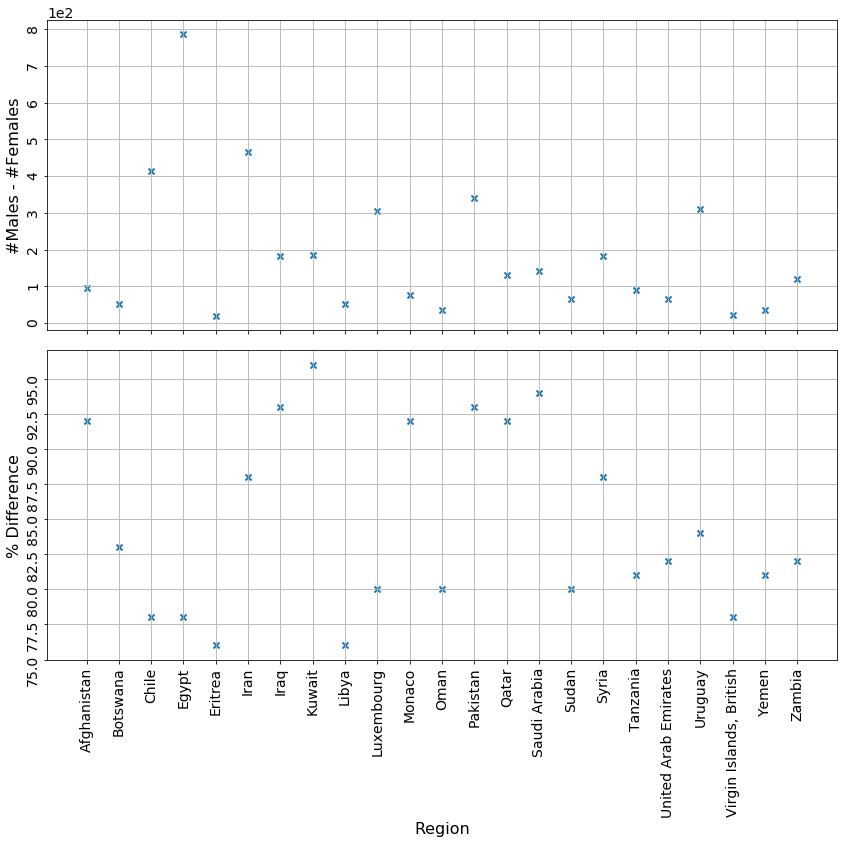

In [4]:
#Query total players from different regions based on their sex - Include datapoints for all the years

male_reg_stats = pysqldf("SELECT Region, COUNT(DISTINCT ID) AS NumMalePlayers \
                        FROM player_stats \
                        WHERE NOT(Region ISNULL) AND SEX='M'\
                        GROUP BY Region ")


female_reg_stats = pysqldf("SELECT Region, COUNT(DISTINCT ID) AS NumFemalePlayers \
                        FROM player_stats \
                        WHERE NOT(Region ISNULL) AND SEX='F'\
                        GROUP BY Sex, Region ")


mf_reg_stats = pysqldf("SELECT ml.Region AS Region, ml.NumMalePlayers AS NumMalePlayers, \
                        fm.NumFemalePlayers AS NuMFemalePlayers, \
                        (ml.NumMalePlayers - fm.NumFemalePlayers) AS Disparity,\
                        (ml.NumMalePlayers - fm.NumFemalePlayers)*100/(ml.NumMalePlayers + fm.NumFemalePlayers) AS Disparity_pct\
                        FROM male_reg_stats AS ml LEFT JOIN female_reg_stats AS fm\
                        ON ml.Region=fm.Region\
                        ORDER BY  Region ")


#Look at countries where more than 75% of players are males (can be changed here)
disparity_pct_cutoff = 75.0
print("Total countriess with disparity > {} = {}".format(disparity_pct_cutoff,mf_reg_stats[mf_reg_stats.Disparity_pct>disparity_pct_cutoff].Region.unique().size ))
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12), sharex=True)

ax1.scatter(mf_reg_stats[mf_reg_stats.Disparity_pct>disparity_pct_cutoff].Region,\
            mf_reg_stats[mf_reg_stats.Disparity_pct>disparity_pct_cutoff].Disparity, marker='x')
#ax1.set_xlabel('Region')
ax1.set_ylabel('#Males - #Females')
ax1.tick_params(labelrotation=90)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax2.scatter(mf_reg_stats[mf_reg_stats.Disparity_pct>disparity_pct_cutoff].Region,\
            mf_reg_stats[mf_reg_stats.Disparity_pct>disparity_pct_cutoff].Disparity_pct, marker='x')
ax2.set_xlabel('Region')
ax2.set_ylabel('% Difference')
ax2.tick_params(labelrotation=90)

plt.tight_layout()
plt.show()
plt.close()


** Analysis ** - From the plot above, we see that the gender inequality in sports is significant across the world with 23 countries having gender disparity > 75%. As our initial hypothesis, most of these countries are developing nations, which have been known to have restrictive laws towards woman rights and freedom compared to developed nations. 

Let's see how this looks on a world map to get a better picture of disparity distribution across the world. This would make it easier to relate with development index, gender inequality and population dynamics etc. 

In [5]:
import plotly
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go


mapdata =  pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

#Let us check if there are any missing countries/ mismatching data
#print(mapdata.COUNTRY.unique())
print("Following country names not found in the \'2014_world_gdp_with_codes\' dataset")
for region in mf_reg_stats.Region.unique():
    country_found=False
    for country in mapdata.COUNTRY.unique():
        if region in country:
            country_found=True
            
    if country_found==False:
        print("{} ".format(region))
            


Following country names not found in the '2014_world_gdp_with_codes' dataset
Boliva 
Cape Verde 
Democratic Republic of the Congo 
Individual Olympic Athletes 
Ivory Coast 
Myanmar 
Nauru 
North Korea 
Palestine 
Republic of Congo 
South Korea 
UK 
USA 
Virgin Islands, British 
Virgin Islands, US 


A quick look in the dataset shows that most of these regions have slightly different names. Let's modify out database to correct for these regions. 

In [6]:
mf_reg_stats_corrected = pysqldf("SELECT *, \
                                 (CASE WHEN Region='Boliva' THEN 'Bolivia'\
                                      WHEN Region='Cape Verde' THEN 'Cabo Verde'\
                                      WHEN Region='Democratic Republic of the Congo' THEN 'Congo, Democratic Republic of the'\
                                      WHEN Region='Ivory Coast' THEN 'Cote d''Ivoire'\
                                      WHEN Region='Myanmar' THEN 'Burma'\
                                      WHEN Region='North Korea' THEN 'Korea, North'\
                                      WHEN Region='Republic of Congo' THEN 'Congo, Republic of the'\
                                      WHEN Region='South Korea' THEN 'Korea, South' \
                                      WHEN Region='UK' THEN 'United Kingdom'\
                                      WHEN Region='USA' THEN 'United States'\
                                      WHEN Region='Virgin Islands, British' THEN 'British Virgin Islands'\
                                      WHEN Region='Virgin Islands, US' THEN 'Virgin Islands' \
                                      ELSE Region END) AS Country\
                                 FROM mf_reg_stats ")

#print(sorted(mf_reg_stats_corrected.Country.unique()))

In [7]:
#px.data.gapminder().query("year==2007")
df = pysqldf("SELECT mapdata.*, COALESCE(mf_reg_stats_corrected.Disparity_pct,0) AS Disparity_pct FROM mapdata LEFT JOIN mf_reg_stats_corrected ON mapdata.COUNTRY=mf_reg_stats_corrected.Country")
figdir = '/Users/bhaveshkhamesra/Documents/GeorgiaTech/CourseEra/SQL_Course4/Presentations'

fig = go.Figure(data=go.Choropleth(
    locations = df['CODE'],
    z = df['Disparity_pct'],
    text = df['COUNTRY'],
    colorscale = 'Inferno',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_ticksuffix = '%',
    colorbar_title = 'Disparity(%)<br>',
))

fig.update_layout(
    title_text='Olympic Players - Regional Disparity',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    
)

fig.show()


In [8]:
#plotly.io.orca.config.executable = '/Users/bhaveshkhamesra/Softwares/anaconda2/envs/sparkpy/'
#fig.write_image(os.path.join(figdir,'WorldMap1.png'),  height=800, width=1200, scale=10)

From the above distribution, most of the countries in the world have disparity > 30%. Few countries like China and Bhutan have done exceptionally well with almost same or more representation of female players compared with male players. One the other hand, even most of the developed nations have struggled with this challenge with disparity between 30% (like Canada, Australia) all the way to 70% (Portugal, Finland, Belgium, Luxemburg). Most of the developing countries have pretty high disparity percent generally greater than >50% including several Asian, African and South American countries. Many third world countries in Asia, Africa and South America also have significantly high disparity (>70%). 

One can focus on nations with more than 90% disparity in participation. Most of these countries are Islamic nations like Afghanistan, Pakistan, Iran, Iraq, Qutar, Saudi Arabia and Seria where more than 90% of sports players are men. This isn't unexpected as some of these countries have been infamous for restrictive laws and policies towards woman's rights and freedom. Some of these countries are also economically underdeveloped which can also be an important factor. However, one should note that the problem is not because of religion but more about the local policies of each nation. 

We note that here we have included the entire dataset from all the years since 1896. To get a more recent picture, it will be better to look at more recent dataset. Also, it will be interesting to see how country's economic growth and development index is related with the disparity factor. 




Total countriess with disparity > 75.0 = 14


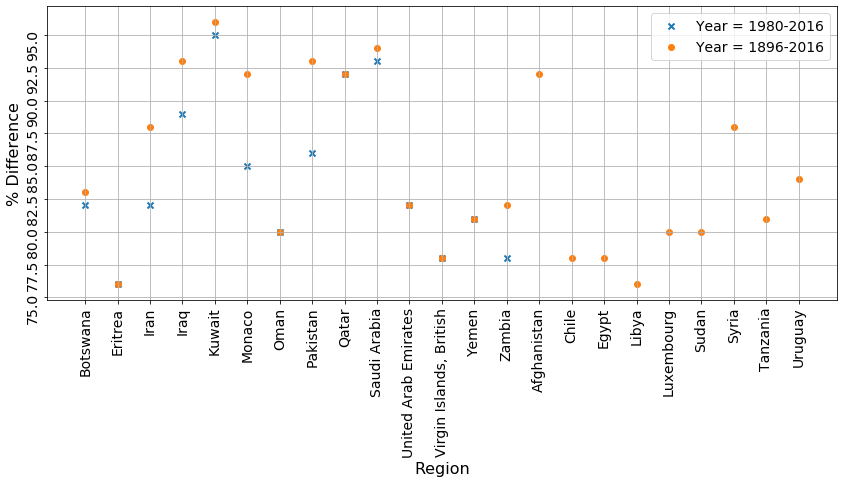

In [9]:
#Query total players from different regions based on their sex - Include datapoints for all the years

male_reg_stats_1980 = pysqldf("SELECT Region, COUNT(DISTINCT ID) AS NumMalePlayers \
                        FROM player_stats \
                        WHERE NOT(Region ISNULL) AND SEX='M' AND Year>1980\
                        GROUP BY Region ")


female_reg_stats_1980 = pysqldf("SELECT Region, COUNT(DISTINCT ID) AS NumFemalePlayers \
                        FROM player_stats \
                        WHERE NOT(Region ISNULL) AND SEX='F' AND Year>1980\
                        GROUP BY Sex, Region ")


mf_reg_stats_1980 = pysqldf("SELECT ml.Region AS Region, ml.NumMalePlayers AS NumMalePlayers, \
                        fm.NumFemalePlayers AS NuMFemalePlayers, \
                        (ml.NumMalePlayers - fm.NumFemalePlayers) AS Disparity,\
                        (ml.NumMalePlayers - fm.NumFemalePlayers)*100/(ml.NumMalePlayers + fm.NumFemalePlayers) AS Disparity_pct\
                        FROM male_reg_stats_1980 AS ml LEFT JOIN female_reg_stats_1980 AS fm\
                        ON ml.Region=fm.Region\
                        ORDER BY  Region ")

mf_reg_stats_corrected = pysqldf("SELECT *, \
                                 (CASE WHEN Region='Boliva' THEN 'Bolivia'\
                                      WHEN Region='Cape Verde' THEN 'Cabo Verde'\
                                      WHEN Region='Democratic Republic of the Congo' THEN 'Congo, Democratic Republic of the'\
                                      WHEN Region='Ivory Coast' THEN 'Cote d''Ivoire'\
                                      WHEN Region='Myanmar' THEN 'Burma'\
                                      WHEN Region='North Korea' THEN 'Korea, North'\
                                      WHEN Region='Republic of Congo' THEN 'Congo, Republic of the'\
                                      WHEN Region='South Korea' THEN 'Korea, South' \
                                      WHEN Region='UK' THEN 'United Kingdom'\
                                      WHEN Region='USA' THEN 'United States'\
                                      WHEN Region='Virgin Islands, British' THEN 'British Virgin Islands'\
                                      WHEN Region='Virgin Islands, US' THEN 'Virgin Islands' \
                                      ELSE Region END) AS Country\
                                 FROM mf_reg_stats_1980 ")

#print(sorted(mf_reg_stats_corrected.Country.unique()))

#Look at countries where more than 75% of players are males (can be changed here)
disparity_pct_cutoff = 75.0



#px.data.gapminder().query("year==2007")
df = pysqldf("SELECT mapdata.*, COALESCE(mf_reg_stats_corrected.Disparity_pct,0) AS Disparity_pct FROM mapdata LEFT JOIN mf_reg_stats_corrected ON mapdata.COUNTRY=mf_reg_stats_corrected.Country")


fig = go.Figure(data=go.Choropleth(
    locations = df['CODE'],
    z = df['Disparity_pct'],
    text = df['COUNTRY'],
    colorscale = 'Inferno',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_ticksuffix = '%',
    colorbar_title = 'Disparity(%)<br>',
))

fig.update_layout(
    title_text='Olympic Players - Regional Disparity (since 1980)',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    
)

fig.show()

print("Total countriess with disparity > {} = {}".format(disparity_pct_cutoff,mf_reg_stats_corrected[mf_reg_stats_corrected.Disparity_pct>disparity_pct_cutoff].Region.unique().size ))
fig, (ax1) = plt.subplots(1,1, figsize=(12,7), sharex=True)

ax1.scatter(mf_reg_stats_1980[mf_reg_stats_1980.Disparity_pct>disparity_pct_cutoff].Region,\
         mf_reg_stats_1980[mf_reg_stats_1980.Disparity_pct>disparity_pct_cutoff].Disparity_pct, marker='x', label='Year = 1980-2016')
ax1.scatter(mf_reg_stats[mf_reg_stats.Disparity_pct>disparity_pct_cutoff].Region,\
          mf_reg_stats[mf_reg_stats.Disparity_pct>disparity_pct_cutoff].Disparity_pct, marker='o', label='Year = 1896-2016')
ax1.set_xlabel('Region')
ax1.set_ylabel('% Difference')
ax1.tick_params(labelrotation=90)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

As can be seen from above plots, the situation around the world has considerably improved. For most developed countries and developing countries, the disparity is less than 40%. Countries like China and Burma has reversed the trend with more female players than male players participating in the Olympics. The situation has also improved in many Islamic nations with disparity reducing to less than 70% though for some countries like Iran, Iraq, Saudi Arabia etc, even in the modern times, the situation hasn't changed much which can be concerning issue. 
The above plot shows countries with more htan 75% disparity and is predominantly occupied by Islamic nations. To see if the disparity has actually changed with time, let's look at disparity as function of time (for all regions combined). 

Correlation between year and % disparity = -0.9613963964673047


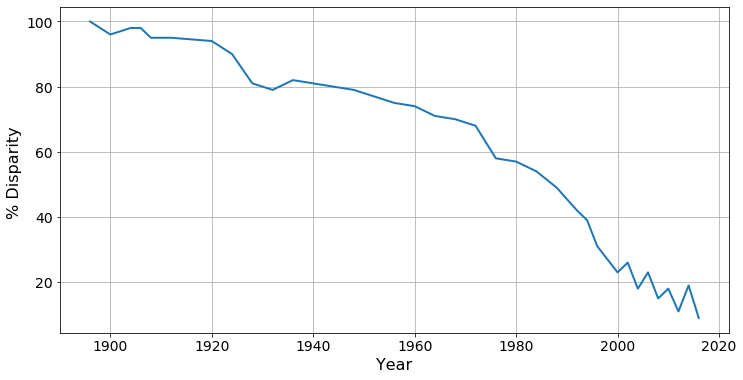

In [10]:
male_year_stats = pysqldf("SELECT Year, COUNT(DISTINCT ID) AS NumMalePlayers \
                        FROM player_stats \
                        WHERE SEX='M' \
                        GROUP BY Year ")


female_year_stats = pysqldf("SELECT Year, COUNT(DISTINCT ID) AS NumFemalePlayers \
                        FROM player_stats \
                        WHERE SEX='F' \
                        GROUP BY Year ")


mf_year_stats = pysqldf("SELECT ml.Year AS Year, COALESCE(ml.NumMalePlayers,0) AS NumMalePlayers, \
                        COALESCE(fm.NumFemalePlayers,0) AS NuMFemalePlayers, \
                        (COALESCE(ml.NumMalePlayers,0) - COALESCE(fm.NumFemalePlayers,0)) AS Disparity,\
                        (COALESCE(ml.NumMalePlayers,0) - COALESCE(fm.NumFemalePlayers,0))*100/\
                        (COALESCE(ml.NumMalePlayers,0) + COALESCE(fm.NumFemalePlayers,0)) AS Disparity_pct\
                        FROM male_year_stats AS ml LEFT JOIN female_year_stats AS fm\
                        ON ml.Year=fm.Year\
                        ORDER BY Year ")

#print(mf_year_stats.head(10))
disparity_fit = np.polyfit(mf_year_stats.Year, mf_year_stats.Disparity_pct, 2)
correlation = np.corrcoef(mf_year_stats.Year, mf_year_stats.Disparity_pct)[0,1]
print("Correlation between year and % disparity = {}".format(correlation))
plt.figure(figsize=(12,6))
plt.plot(mf_year_stats.Year, mf_year_stats.Disparity_pct)
plt.plot()
plt.xlabel('Year')
plt.ylabel('% Disparity ')
plt.show()
plt.close()

Correlation between year and % disparity = -0.9613963964673047


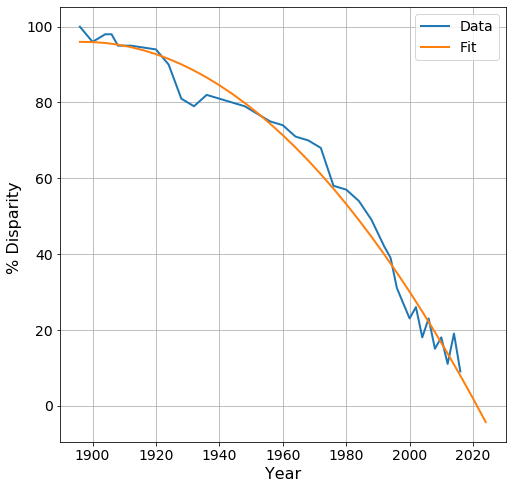

In [11]:
#print(mf_year_stats.head(10))
disparity_fit = np.poly1d(np.polyfit(mf_year_stats.Year, mf_year_stats.Disparity_pct, 2))
correlation = np.corrcoef(mf_year_stats.Year, mf_year_stats.Disparity_pct)[0,1]

year_predict = np.arange(1896, 2028, 4)
print("Correlation between year and % disparity = {}".format(correlation))
plt.figure(figsize=(8,8))
plt.plot(mf_year_stats.Year, mf_year_stats.Disparity_pct, label='Data')
plt.plot(year_predict,disparity_fit(year_predict), label='Fit')
plt.plot()
plt.xlabel('Year')
plt.ylabel('% Disparity ')
plt.legend()
plt.show()
plt.close()

Here we have a plot showing how the gender disparity in Olympics has changed over the years. The strong negative correlation shows the participation of woman has improved significantly since 1896 with current disparity about 15%. 

##  Player's Age and Sport Type

To analyse this, let's look at the average age of players as function of sports they play. 

Median age for all players = 25.809714214873765 
Mean age of all players = 27.2500319247797 
Standard Deviation = 5.345131999498751


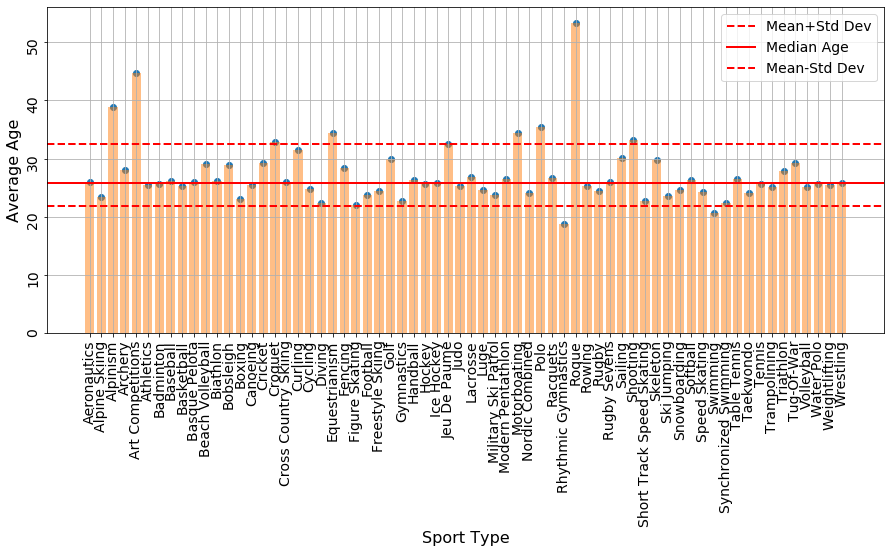

In [12]:
# Query to find the average age for each sportss
age_stats = pysqldf("SELECT  Sport, AVG(Age) AS Avg_Age \
                    FROM \
                         (SELECT  ID, Sport, Age  \
                          FROM player_stats \
                          WHERE NOT(Age ISNULL) \
                          GROUP BY ID, Age )\
                    GROUP BY Sport")

#print(age_stats)
#Let's compute the basic stats - Mean, median and standard deviation
mean_age = age_stats.Avg_Age.mean()
std_dev = age_stats.Avg_Age.std()
median_age = age_stats.Avg_Age.median()
print("Median age for all players = {} \nMean age of all players = {} \nStandard Deviation = {}"\
      .format(age_stats.Avg_Age.median(),age_stats.Avg_Age.mean(), age_stats.Avg_Age.std()))

#Let's plot the data
plt.figure(figsize=(15,6))
plt.scatter(np.arange(len(age_stats.Sport)), age_stats.Avg_Age)#, align='center', alpha=0.5)
plt.bar(np.arange(len(age_stats.Sport)), age_stats.Avg_Age, align='center', alpha=0.5)
plt.xticks(np.arange(len(age_stats.Sport)), age_stats.Sport)
#plt.axhline(y=25)
plt.axhline(y=mean_age+std_dev, ls='--', c='r',label="Mean+Std Dev")
plt.axhline(y=median_age, label='Median Age')
plt.axhline(y=mean_age-std_dev,  ls='--', c='r',label="Mean-Std Dev")

plt.xlabel('Sport Type')
plt.ylabel('Average Age')
plt.tick_params(labelrotation=90)
plt.legend()
plt.show()
plt.close()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1284f1790>]],
      dtype=object)

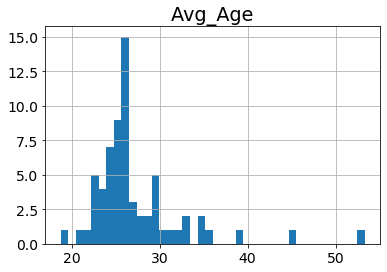

In [13]:
age_stats.hist(bins=40)

**Analysis** - The plot above shows that for most sports, the average age falls in the bracket of $27.2  \pm  5.3$ years. Hence, there doesn't seem any strong dependence between the average and sport type. There are some clear outliers such as Alpinism, Art Competitions, Equestrianism, Motorboating, Polo, Rhythmic Gymnastics, Roque and Swimming. For Alpinism, Art Competitions, Equestrianism, Motorboating, Polo, and Roque, the average age is significantly higher than average which suggests that experience is more relevant in these sports. On the other hand, for swimming and gymnastics, agility is favoured over experience. 


Let's compare how this distribution and the conclusion change when we consider only the top contenders from each sport event. Note that, here we assume that the average age of players  would not be significantly affected over the years and ignore the variations of mean age over time for each sport. 



Median age for top players = 25.809714214873765, Median age for top players = 25.91590624813866
Mean age of all players = 27.2500319247797, Mean age of top players = 27.363821595864305
Standard Deviation for all players = 5.345131999498751, Standard Deviation for top players= 5.11984278609164


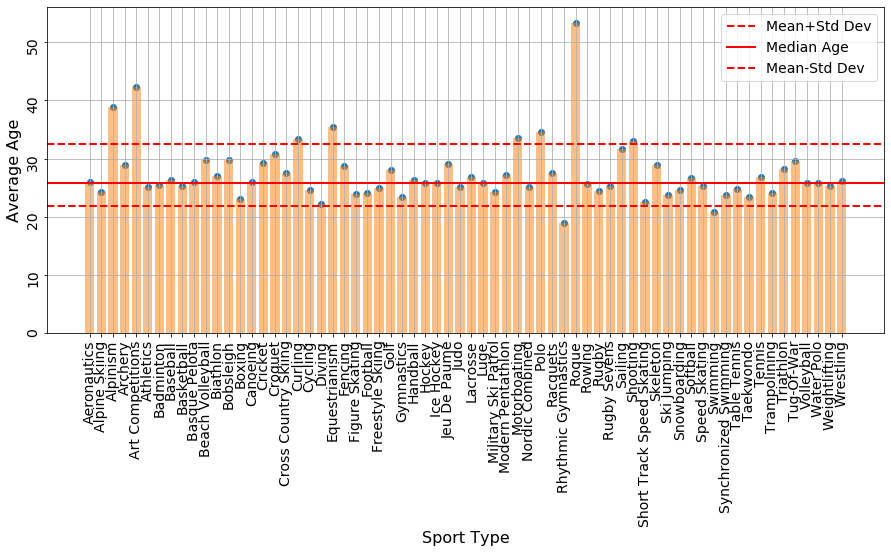

In [14]:
# Query to find the average age for each sportss
age_stats_topplayers = pysqldf("SELECT  Sport, AVG(Age) AS Avg_Age \
                    FROM \
                         (SELECT  ID, Sport, Age  \
                          FROM player_stats \
                          WHERE NOT(Age ISNULL)  AND NOT(Medal ISNULL)\
                          GROUP BY ID, Age )\
                    GROUP BY Sport")

#print(age_stats_topplayers)
#Let's compute the basic stats - Mean, median and standard deviation
mean_age_tp = age_stats_topplayers.Avg_Age.mean()
std_dev_tp = age_stats_topplayers.Avg_Age.std()
median_age_tp = age_stats_topplayers.Avg_Age.median()


print("Median age for top players = {}, Median age for top players = {}".format(median_age, median_age_tp))
      
print("Mean age of all players = {}, Mean age of top players = {}".format(mean_age, mean_age_tp))
print("Standard Deviation for all players = {}, Standard Deviation for top players= {}".format(std_dev, std_dev_tp))

#Let's plot the data
plt.figure(figsize=(15,6))
plt.scatter(np.arange(len(age_stats_topplayers.Sport)), age_stats_topplayers.Avg_Age)#, align='center', alpha=0.5)
plt.bar(np.arange(len(age_stats_topplayers.Sport)), age_stats_topplayers.Avg_Age, align='center', alpha=0.5)
plt.xticks(np.arange(len(age_stats_topplayers.Sport)), age_stats_topplayers.Sport)
#plt.axhline(y=25)
plt.axhline(y=mean_age+std_dev, ls='--', c='r',label="Mean+Std Dev")
plt.axhline(y=median_age, label='Median Age')
plt.axhline(y=mean_age-std_dev,  ls='--', c='r',label="Mean-Std Dev")

plt.xlabel('Sport Type')
plt.ylabel('Average Age')
plt.tick_params(labelrotation=90)
plt.legend()
plt.show()
plt.close()

As we see here, the results don't change significantly with only minors differences in mean age and standard deviation. Thus we can conclude that average age of most sports do not vary significantly and lies with 1-sigma of age distribution with average age of ~$26$ years with standard deviation of $\pm 5$ years. 

## Dominance of Countries

Here we want to look at the performance of countries in the olympics and wish to see if certain countries have always dominated majority of olympic events over the years or if there is uniform variation across the sport events and leading countries have changed over the years. 

To do this, let's first look at the top ten leading countries in total events tally for all the olympic events. We  can also rank them based on event tally for each game and look at countries which have consistently finished in top ten. Here we use both these statistics and compare them at the end. 

In [15]:
#Let's remove the records with  no regions
games_with_only_medals = pysqldf("SELECT ID, Games, Year, Event, Sport, Region, COALESCE(Medal, 'None') AS Medal\
                                FROM player_stats \
                                WHERE NOT(Region ISNULL)")
games_with_only_medals.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270746 entries, 0 to 270745
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      270746 non-null  int64 
 1   Games   270746 non-null  object
 2   Year    270746 non-null  int64 
 3   Event   270746 non-null  object
 4   Sport   270746 non-null  object
 5   Region  270746 non-null  object
 6   Medal   270746 non-null  object
dtypes: int64(2), object(5)
memory usage: 14.5+ MB


In [16]:
#Now let's look at total number of events played during these games
total_events = pysqldf("SELECT Games, Year, Event\
                       FROM games_with_only_medals\
                       GROUP BY Games, Year, Event")

#print(total_events.Event.unique())
num_total_events = total_events.Event.size
print("Total number of events played in all the games = {}\n".format(total_events.Event.size))
print("It might seem peculiar that although number of events are {}, but number of medals are more then 3 times \
of this. However, recall that in Olympics, apart from individual events, there are also team events where instead \
of 3, there can be more than 45 medals awarded per such event. For example, In Rugby Men's Team event for year \
1900 had 47 medals awarded in total (Check the stats below)".format(total_events.Event.size))

Total number of events played in all the games = 6192

It might seem peculiar that although number of events are 6192, but number of medals are more then 3 times of this. However, recall that in Olympics, apart from individual events, there are also team events where instead of 3, there can be more than 45 medals awarded per such event. For example, In Rugby Men's Team event for year 1900 had 47 medals awarded in total (Check the stats below)


In [17]:
#Example - Rugby Men's Team event for year 1900 had 47 medals awarded in total
pd.set_option('display.max_colwidth', 100)
rugby_medals = pysqldf("SELECT COUNT(Medal) AS 'Total Medals Awarded'\
                        FROM (\
                              SELECT Games, Year, Event, Region, ID, Medal\
                              FROM games_with_only_medals\
                              WHERE Event LIKE '%Rugby Men%'\
                              AND Year=1900\
                              GROUP BY Games, Year, Event, Medal, ID)\
                       ")

print("Total medals awarded in Rugby Men's Team event in 1900 = {}".format(int(rugby_medals["Total Medals Awarded"])))


Total medals awarded in Rugby Men's Team event in 1900 = 47


Top 5 countries which won highest number of events -  
    Region  Total_Events_Won  Event_Won_Pct
0      USA              2110      34.076227
1   Russia              1638      26.453488
2  Germany              1510      24.386305
3       UK               790      12.758398
4   France               767      12.386951


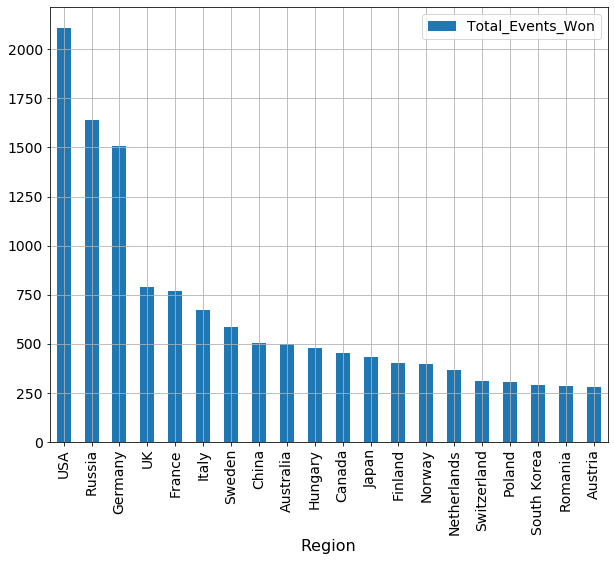

In [18]:
#Now let's look at top 40 countries who won maximum number of events. 
total_events_per_reg = pysqldf("SELECT Region, Count(Event_Won) AS Total_Events_Won,\
                                Count(Event_Won)*100./{} AS Event_Won_Pct\
                                FROM(\
                                      SELECT Games, Year, Region, Event AS Event_Won\
                                      FROM games_with_only_medals\
                                      WHERE NOT(Medal LIKE 'None')\
                                      GROUP BY Games, Year, Event, Region\
                                     )\
                                GROUP BY Region ORDER BY Count(Event_Won) DESC  LIMIT 20\
                                ".format(num_total_events))

print("Top 5 countries which won highest number of events -  ")
print(total_events_per_reg.head(5))
bar = total_events_per_reg.plot.bar(x='Region', y='Total_Events_Won', rot=90, figsize=(10,8))
#game_hist.set_ylabel('Number of Medals') 



From the above plot, USA, Russsia and Germany clearly standout winning about 34%, 26% and  24% of the total events ever occured in Olympics. This suggest that few countries have clearly dominated the Olympic games. Let's rank the countries based on their event tally for each game and look at the countries which have appeared maximum number of times in top ten places. 

Total games over years = 35
    Region  Num_Times_In_Top_Ten
0      USA                    34
1  Germany                    32
2   France                    27
3    Italy                    26
4       UK                    23


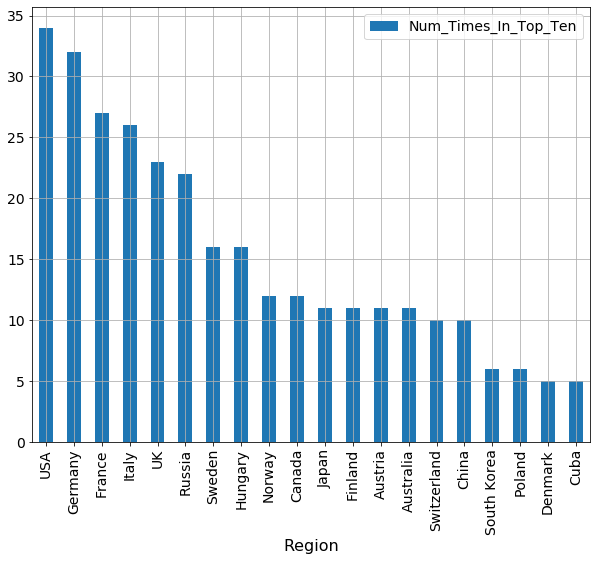

In [19]:
#Top ten countries who won maximum number of events per game
event_stats_per_game = pysqldf("SELECT *\
                                FROM \
                                    (SELECT  Year, Region, Count(Event) as EventCount,\
                                    RANK() OVER (PARTITION BY Year ORDER BY COUNT(Event) DESC) AS Ranking \
                                    FROM (\
                                          SELECT Year, Region, Event\
                                          FROM player_stats \
                                          WHERE NOT(Medal ISNULL) \
                                          GROUP BY Year, Region, Event \
                                          ORDER BY Year ASC, Event DESC\
                                          )\
                                    GROUP BY Year, Region\
                                    ) \
                                    WHERE ranking<10")

#Let's now check countries who have consistently performed better than others
top_performers_per_game = pysqldf("SELECT Region, Count(Ranking) AS Num_Times_In_Top_Ten\
                                    FROM event_stats_per_game \
                                    GROUP BY Region\
                                    ORDER BY COUNT(Ranking) DESC LIMIT 20")

print("Total games over years = {}".format(player_stats.Year.unique().size))
print(top_performers_per_game.head(5))
bar = top_performers_per_game.plot.bar(x='Region', y='Num_Times_In_Top_Ten', rot=90, figsize=(10,8))
#game_hist.set_ylabel('Number of Medals') 


The above plot shows list of countries which have consistently performed in Olympics. x axis lists the name of countries and y axis describes total number of Olympin games in which each country has reached to one of the top ten spots based on number of events won (not number of medals). Here, I have used "total events won" count as ranking criteria since in case of group events, one event would contribute the several medals and hence, medal count can lead to biased picture. 

This is consistent with our previous plot of total events won by countries over entire Olympic history with some changes in country rankings. We see again that USA, Germany, France and UK continue to be in top five leading nations. USA has been most consistent with managing a spot in top ten positions in 34 out of 35 games followed by Germany, France, Itals and UK at 32, 27, 36 and 23. While Russia has won more number of events than Italy, it has not appeared in top ten positions as much as Italy. 

The above two measures show that few countries have clearly dominated the Olympics over all the years. Let's look at the performance of top five countries over time by comparing the number of events won by them in each game. 

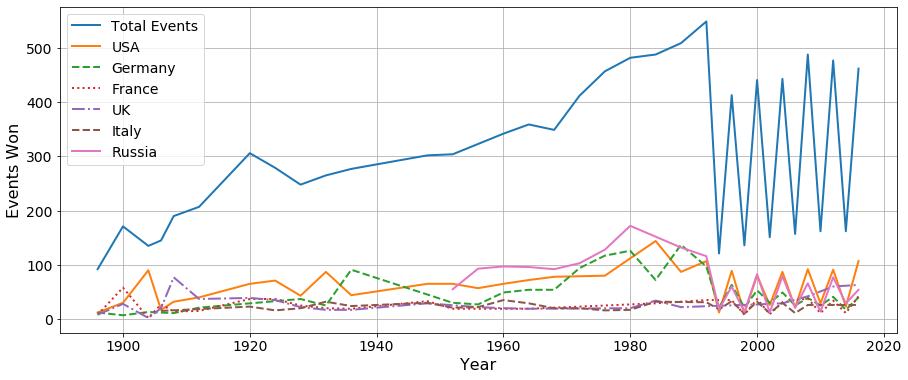

In [20]:
usa_stats = pysqldf("SELECT * FROM event_stats_per_game WHERE Region='USA' ORDER BY Year")
germany_stats = pysqldf("SELECT * FROM event_stats_per_game WHERE Region='Germany' ORDER BY Year")
france_stats = pysqldf("SELECT * FROM event_stats_per_game WHERE Region='France' ORDER BY Year")
uk_stats = pysqldf("SELECT * FROM event_stats_per_game WHERE Region='UK' ORDER BY Year")
italy_stats = pysqldf("SELECT * FROM event_stats_per_game WHERE Region='Italy' ORDER BY Year")
russia_stats = pysqldf("SELECT * FROM event_stats_per_game WHERE Region='Russia' ORDER BY Year")
total_events = pysqldf("SELECT Year, SUM(EventCount) AS TotalEvents FROM event_stats_per_game GROUP BY Year ORDER BY Year")


plt.figure(figsize=(15,6))
plt.plot(total_events.Year, total_events.TotalEvents, label='Total Events')
plt.plot(usa_stats.Year, usa_stats.EventCount, label='USA')
plt.plot(germany_stats.Year, germany_stats.EventCount, ls='--', label='Germany')
plt.plot(france_stats.Year, france_stats.EventCount, ls=':',label='France')
plt.plot(uk_stats.Year, uk_stats.EventCount, ls='-.',label='UK')
plt.plot(italy_stats.Year, italy_stats.EventCount, ls='--',label='Italy')
plt.plot(russia_stats.Year, russia_stats.EventCount, ls='-',label='Russia')
plt.xlabel('Year')
plt.ylabel('Events Won')
plt.xlim
plt.legend()
plt.show()
plt.close()

Above plot shows the number of events won by top performers - USA, Germany, France, UK, Italy and Russia for each game. The performance of USA had been improving remaining the best out of the six nations. Similar results hold for Germany, though after 1990s its performance has been decreasing. UK, France and Italy have almost consistent performance with no significant change till 1990s. UK has since started improving. Even though Russia has won a lot of events, it ranked low in number of times it rose in top ten. This is evident here when we see that Russia's participation in Olympics is mainly recorded after 1952.  A quick online search shows that Russia did not participate in Olympics between 1912-1952 which explains the missing data. 

# Summary


To Summarize - 
* Gender Disparity - To understatnd the gender disparity, we look at the disparity between male and female number of players for each region over all the years. Our initial analysis shows that gender disparity is significant in Olympics with more than 80% players being male in more than 40 countries including some of the developed nations. It will be interesting to see how this trend has changed in recent times. 
* Effect of Age in Sports - Here we look at the average age for each sport type. We see that  for most sports, the average age of players is mostly close to 26 and is not significantly affected by sport type as initially predicted. However, there are few outlier sports in which average age of players is much lower than 26 or much higher than 26. 
* Domination of countries - Here we have looked at the total number of events won by each country over all the years and how many times a country has reached in top 10 for a game. These two metrics can be used to see if few nations have dominated the world of Olympics. In line with our initial hypothesis, we find that certain developed countries have been major winner in these sports like USA, Germany, France etc. 

It will be interesting to dig more into these issues. More specifically has gender disparity changed in recent times? Does the relation between age and sports continues to hold when we consider only top contenders three players from each event. How has the nation tally changed in the recent years?